1D wave equation with absorbing (Dirichlet), or Neumann bdy conditions
and variable wave velocity:

> `u, x, t, cpu = solver(I, V, f, c, U_0, U_L, L, dt, C, T,
                       user_action=None, version='scalar',
                       stability_safety_factor=1.0)`

Solve the wave equation 

$$u_{tt} = (c^2 u_x)_x + f(x,t)$$ 

on $(0,L)$ with
 
 - $u=U_0$ or $du/dn=0$ on $x=0,$ and 
 - $u=u_L$ or $du/dn=0$ on $x = L.$ 

If U_0 or U_L equals None, the $du/dn=0$ Neumann condition
is used, otherwise U_0(t) and/or U_L(t) are used for advanced absorbing conditions.

Initial conditions: $u=I(x),$ $u_t=V(x).$

- T is the stopping time for the simulation.
- dt is the desired time step.
- C is the Courant number (=max(c)*dt/dx).
- stability_safety_factor enters the stability criterion:

    C <= stability_safety_factor (<=1).

I, f, U_0, U_L, and c are functions: $I(x),$ $f(x,t),$ $U_0(t),$
$U_L(t),$ $c(x).$
U_0 and U_L can also be 0, or None, where None implies
$du/dn=0$ boundary condition. f and V can also be 0 or None
(equivalent to 0). c can be a number or a function c(x).

`user_action` is a function of (u, x, t, n) where the calling code
can add visualization, error computations, data analysis,
store solutions, etc.

In [ ]:
import time, glob, shutil, os
import numpy as np

def solver(
    I, V, f, c, U_0, U_L, L, dt, C, T,
    user_action=None,
    stability_safety_factor=1.0):
    """Solve u_tt=(c^2*u_x)_x + f on (0,L)x(0,T]."""

    # --- Compute time and space mesh ---
    Nt = int(round(T/dt))
    t = np.linspace(0, Nt*dt, Nt+1)      # Mesh points in time

    # Find max(c) using a fake mesh and adapt dx to C and dt
    if isinstance(c, (float,int)):
        c_max = c
    elif callable(c):
        c_max = max([c(x_) for x_ in np.linspace(0, L, 101)])
    dx = dt*c_max/(stability_safety_factor*C)
    Nx = int(round(L/dx))
    x = np.linspace(0, L, Nx+1)          # Mesh points in space
    # Make sure dx and dt are compatible with x and t
    dx = x[1] - x[0]
    dt = t[1] - t[0]

    # Make c(x) available as array
    if isinstance(c, (float,int)):
        c = np.zeros(x.shape) + c
    elif callable(c):
        # Call c(x) and fill array c
        c_ = np.zeros(x.shape)
        for i in range(Nx+1):
            c_[i] = c(x[i])
        c = c_

    q = c**2
    C2 = (dt/dx)**2; dt2 = dt*dt    # Help variables in the scheme

    # --- Wrap user-given f, I, V, U_0, U_L if None or 0 ---
    if f is None or f == 0:
        f = lambda x, t: np.zeros(x.shape)
    if I is None or I == 0:
        I = lambda x: np.zeros(x.shape)
    if V is None or V == 0:
        V = lambda x: np.zeros(x.shape)
    if U_0 is not None:
        if isinstance(U_0, (float,int)) and U_0 == 0:
            U_0 = lambda t: 0
    if U_L is not None:
        if isinstance(U_L, (float,int)) and U_L == 0:
            U_L = lambda t: 0

    # --- Make hash of all input data ---
    import hashlib, inspect
    data = inspect.getsource(I) + '_' + inspect.getsource(V) + \
           '_' + inspect.getsource(f) + '_' + str(c) + '_' + \
           ('None' if U_0 is None else inspect.getsource(U_0)) + \
           ('None' if U_L is None else inspect.getsource(U_L)) + \
           '_' + str(L) + str(dt) + '_' + str(C) + '_' + str(T) + \
           '_' + str(stability_safety_factor)
    hashed_input = hashlib.sha1(data.encode('utf-8')).hexdigest()
    if os.path.isfile('.' + hashed_input + '_archive.npz'):
        # Simulation is already run
        return -1, hashed_input

    # --- Allocate memomry for solutions ---
    u     = np.zeros(Nx+1)   # Solution array at new time level
    u_n   = np.zeros(Nx+1)   # Solution at 1 time level back
    u_nm1 = np.zeros(Nx+1)   # Solution at 2 time levels back

    import time;  t0 = time.process_time()  # CPU time measurement

    # --- Valid indices for space and time mesh ---
    Ix = range(0, Nx+1)
    It = range(0, Nt+1)

    # --- Load initial condition into u_n ---
    for i in range(0,Nx+1):
        u_n[i] = I(x[i])

    if user_action is not None:
        user_action(u_n, x, t, 0)

    # --- Special formula for the first step ---
    for i in Ix[1:-1]:
        u[i] = u_n[i] + dt*V(x[i]) + \
        0.5*C2*(0.5*(q[i] + q[i+1])*(u_n[i+1] - u_n[i]) - \
                0.5*(q[i] + q[i-1])*(u_n[i] - u_n[i-1])) + \
        0.5*dt2*f(x[i], t[0])

    i = Ix[0]
    if U_0 is None:
        # Set boundary values (x=0: i-1 -> i+1 since u[i-1]=u[i+1]
        # when du/dn = 0, on x=L: i+1 -> i-1 since u[i+1]=u[i-1])
        ip1 = i+1
        im1 = ip1  # i-1 -> i+1
        u[i] = u_n[i] + dt*V(x[i]) + \
               0.5*C2*(0.5*(q[i] + q[ip1])*(u_n[ip1] - u_n[i])  - \
                       0.5*(q[i] + q[im1])*(u_n[i] - u_n[im1])) + \
        0.5*dt2*f(x[i], t[0])
    else:
        u[i] = U_0(dt)

    i = Ix[-1]
    if U_L is None:
        im1 = i-1
        ip1 = im1  # i+1 -> i-1
        u[i] = u_n[i] + dt*V(x[i]) + \
               0.5*C2*(0.5*(q[i] + q[ip1])*(u_n[ip1] - u_n[i])  - \
                       0.5*(q[i] + q[im1])*(u_n[i] - u_n[im1])) + \
        0.5*dt2*f(x[i], t[0])
    else:
        u[i] = U_L(dt)

    if user_action is not None:
        user_action(u, x, t, 1)

    # Update data structures for next step
    #u_nm1[:] = u_n;  u_n[:] = u  # safe, but slower
    u_nm1, u_n, u = u_n, u, u_nm1

    # --- Time loop ---
    for n in It[1:-1]:
        # Update all inner points
        u[1:-1] = - u_nm1[1:-1] + 2*u_n[1:-1] + \
        C2*(0.5*(q[1:-1] + q[2:])*(u_n[2:] - u_n[1:-1]) -
            0.5*(q[1:-1] + q[:-2])*(u_n[1:-1] - u_n[:-2])) + \
            dt2*f(x[1:-1], t[n])
        # Insert boundary conditions
        i = Ix[0]
        if U_0 is None:
            # Set boundary values
            # x=0: i-1 -> i+1 since u[i-1]=u[i+1] when du/dn=0
            # x=L: i+1 -> i-1 since u[i+1]=u[i-1] when du/dn=0
            ip1 = i+1
            im1 = ip1
            u[i] = - u_nm1[i] + 2*u_n[i] + \
                   C2*(0.5*(q[i] + q[ip1])*(u_n[ip1] - u_n[i])  - \
                       0.5*(q[i] + q[im1])*(u_n[i] - u_n[im1])) + \
            dt2*f(x[i], t[n])
        else:
            u[i] = U_0(t[n+1])

        i = Ix[-1]
        if U_L is None:
            im1 = i-1
            ip1 = im1
            u[i] = - u_nm1[i] + 2*u_n[i] + \
                   C2*(0.5*(q[i] + q[ip1])*(u_n[ip1] - u_n[i])  - \
                       0.5*(q[i] + q[im1])*(u_n[i] - u_n[im1])) + \
            dt2*f(x[i], t[n])
        else:
            u[i] = U_L(t[n+1])

        if user_action is not None:
            if user_action(u, x, t, n+1):
                break

        # Update data structures for next step
        u_nm1, u_n, u = u_n, u, u_nm1

    cpu_time = time.process_time() - t0
    return cpu_time, hashed_input

## Staggered grid formulation

The 1D (acoustic) wave equation in velocity-pressure formulation is a coupled system of two first-order partial differential equations

$$
\rho \frac{\partial v}{\partial t} = \frac{\partial  p}{\partial x} + f 
$$
$$
\frac{\partial p}{\partial t}   = \mu \frac{\partial v}{\partial x}
$$

where,

- $ p $ is the pressure,
- $ \rho $ is the density,
- $ v $ is the velocity,
- $ \mu = \rho c^2 $ is the shear modulus, and
- $ f $ is the source.

For grid staggering, the discrete velocity and pressure are defined on a regularly spaced grid in space and time. Then, partial derivatives are replaced with centered finite-difference approximations of the first derivatives. However, these are not defined at the grid points  but midway between them.
In grid staggering the following computational scheme is used

$$
\frac{v_i^{j+ \tfrac{1}{2}} - v_i^{j- \tfrac{1}{2}} }{\Delta t} \ = \ \frac{1}{\rho_i}\frac{p_{i + \tfrac{1}{2}}^j - p_{i - \tfrac{1}{2}}^j }{h} + \frac{f_i^j}{\rho_i} \
$$

$$
\frac{p_{i+\tfrac{1}{2}}^{j+1} - p_{i+\tfrac{1}{2}}^j }{\Delta t} \ = \ \mu_{i+\tfrac{1}{2}}  \frac{v_{i + 1}^{j +\tfrac{1}{2}} - v_i^{j + \tfrac{1}{2}} }{h}
$$

The explicit scheme becomes

$$
v_i^{j+ \tfrac{1}{2}} \ = \ v_i^{j- \tfrac{1}{2}}  + \frac{\Delta t}{h} \frac{1}{\rho_i}  \left(p_{i + \tfrac{1}{2}}^j - p_{i - \tfrac{1}{2}}^j \right) \  + \frac{\Delta t}{\rho_i} \ f_i^j 
$$

$$
p_{i+\tfrac{1}{2}}^{j+1} \ = \  p_{i+\tfrac{1}{2}}^j  + \frac{\Delta t}{h} \ \mu_{i+\tfrac{1}{2}} \left( v_{i + 1}^{j +\tfrac{1}{2}} - v_i^{j + \tfrac{1}{2}} \right) 
$$


**Note that in the codes below we do not deal with the index fractions.** We use the convention

$$  v^{j - \tfrac{1}{2}} \rightarrow v [n-1],$$

$$  v^{j+ \tfrac{1}{2}} \rightarrow v [n],$$

etc.

In [1]:
#def solver_st(I, w, dt, T):
#    """
#    Solve u'=v, v' = - w**2*u for t in (0,T], u(0)=I and v(0)=0,
#    by a central finite difference method with time step dt on
#    a staggered mesh with v as unknown at (i+1/2)*dt time points.
#    """
#    dt = float(dt)
#    Nt = int(round(T/dt))
#    u = zeros(Nt+1)
#    v = zeros(Nt+1)
#    t = linspace(0, Nt*dt, Nt+1)  # mesh for u
#    t_v = t + dt/2                # mesh for v
#
#    u[0] = I
#    v[0+half] = 0 - 0.5*dt*w**2*u[0]
#    for n in range(1, Nt+1):
#        u[n] = u[n-1] + dt*v[n-half]
#        v[n+half] = v[n-half] - dt*w**2*u[n]
#    return u, t, v[:-1], t_v[:-1]

import time, glob, shutil, os
import numpy as np

import matplotlib
# Show plot in the notebook
matplotlib.use("nbagg")

import matplotlib.pyplot as plt

def solver_st(medium, 
    V0, P0, f, c, rho, V_0, V_L, P_0, P_L,
    L, dt, CFL, T, order,
    user_action=None,
    stability_safety_factor=1.0):
    """Solve v_t = 1/rho p_x, p_t = mu p_x + f on (0,L)x(0,T]."""

    # --- Compute time and space mesh ---
    Nt = int(round(T/dt))
    t = np.linspace(0, Nt*dt, Nt+1)      # Mesh points in time

    # Find max(c) using a fake mesh  of 101 points and adapt dx to C and dt
    if isinstance(c, (float,int)):
        c_max = c
    elif callable(c):
        c_max = max([c(x_) for x_ in np.linspace(0, L, 101)])
    # Find min(rho) using a fake mesh of 101 points and adapt dx to C and dt
    if isinstance(rho, (float,int)):
        rho_min = rho
    elif callable(rho):
        rho_min = min([rho(x_) for x_ in np.linspace(0, L, 101)])
    # CFL stability condition
    dx = dt*np.sqrt(c_max/rho_min) / (stability_safety_factor*CFL)
    Nx = int(round(L/dx))
    x = np.linspace(0, L, Nx+1)          # Mesh points in space
    # Make sure dx and dt are compatible with x and t
    dx = x[1] - x[0]
    dt = t[1] - t[0]

    # Make f(x), c(x) available as arrays (leave rho as constant, for the moment)
    if isinstance(c, (float,int)):
        c = np.zeros(x.shape) + c
    elif callable(c):
        # Call c(x) and fill array c
        c_ = np.zeros(x.shape)
        for i in range(Nx+1):
            c_[i] = c(x[i])
        c = c_
    #if isinstance(f, (float,int)):
    #   f = np.zeros(t.shape) + f
    #elif callable(f):
    #    # Call f(t) and fill array f
    #    f_ = np.zeros(t.shape)
    #    for i in range(Nt+1):
    #        f_[i] = f(t[i])
    #    f = f_

    r = CFL*(dt/dx) # Helper variable in the scheme
    
    # --- Wrap user-given f, I, V, U_0, U_L if None or 0 ---
    if f is None or f == 0:
        f = lambda x, t: np.zeros(x.shape) # t.shape
    if V0 is None or V0 == 0:  # IC on v
        V0 = lambda x: np.zeros(x.shape)
    if P0 is None or P0 == 0:  # IC on p
        P0 = lambda x: np.zeros(x.shape)
    if V_0 is not None:    # Dirichlet BC
        if isinstance(V_0, (float,int)) and V_0 == 0:
            V_0 = lambda t: 0
    if V_L is not None:    # Dirichlet BC 
        if isinstance(V_L, (float,int)) and V_L == 0:
            V_L = lambda t: 0
    if P_0 is not None:    # Dirichlet BC
        if isinstance(P_0, (float,int)) and P_0 == 0:
            P_0 = lambda t: 0
    if P_L is not None:    # Dirichlet BC 
        if isinstance(P_L, (float,int)) and P_L == 0:
            P_L = lambda t: 0

    # --- Make hash of all input data ---
    import hashlib, inspect
    data = inspect.getsource(V0) + '_' + inspect.getsource(P0) + \
            '_' + inspect.getsource(f) + '_' + str(c) + '_' + \
           ('None' if V_0 is None else inspect.getsource(U_0)) + \
           ('None' if V_L is None else inspect.getsource(U_L)) + \
           '_' + str(L) + str(dt) + '_' + str(CFL) + '_' + str(T) + \
           '_' + str(stability_safety_factor)
           #'_' + inspect.getsource(f) + '_' + str(c) + '_' + \
    hashed_input = hashlib.sha1(data.encode('utf-8')).hexdigest()
    if os.path.isfile('.' + hashed_input + '_archive.npz'):
        # Simulation is already run
        return -1, hashed_input

    # --- Allocate memomry for solutions ---
    v     = np.zeros(Nx+1)   # Solution array at new time level
    p     = np.zeros(Nx+1)   # Solution array at new time level
    dv    = np.zeros(Nx+1)   # Solution difference at 1 time level back
    dp    = np.zeros(Nx+1)   # Solution difference at 1 time level back

    import time;  t0 = time.process_time()  # CPU time measurement

    # --- Valid indices for space and time mesh ---
    Ix = range(0, Nx+1)
    It = range(0, Nt+1)

    # --- Load initial condition into v ---
    for i in range(0,Nx+1):
        v[i] = V0(x[i])
    # --- Load initial condition into p ---
    for i in range(0,Nx+1):
        p[i] = P0(x[i])

    #if user_action is not None:
    #    user_action(v, p, x, t, 0)
    # Initialize the plot
    x_L, x_R = medium
    umin = -0.5
    umax = 1.5
    title = "FD Elastic 1D staggered grid"
    fig = plt.figure(figsize=(10,8))
    ax1 = fig.add_subplot(2, 1, 1)
    ax2 = fig.add_subplot(2, 1, 2)
    line1 = ax1.plot(x, v, color = "red", lw = 1.5)
    line2 = ax2.plot(x, p, color = "blue", lw = 1.5)
    ax1.set_ylabel('velocity (m/s)')
    ax2.set_xlabel('x (m)')
    ax2.set_ylabel('pressure (Pa)')
    ax1.axis([x[0], x[-1], umin, umax])
    ax2.axis([x[0], x[-1], umin, umax])
    #line_v = ax1.plot(
    #                #x, u, 'r-',
    #                [x_L, x_L], [umin, umax], 'k--',
    #                [x_R, x_R], [umin, umax], 'k--')
    #line_p = ax2.plot(
    #                #x, u, 'r-',
    #                [x_L, x_L], [umin, umax], 'k--',
    #                [x_R, x_R], [umin, umax],'k--')
    #ax1.text(0.75, 1.0, 'c lower') # assumes slow/fast medium to right of x=0.75
    #ax1.text(0.32, 1.0, 'c=1')
    #ax2.text(0.75, 1.0, 'c lower') # assumes slow/fast medium to right of x=0.75
    #ax2.text(0.32, 1.0, 'c=1')
    #ax1.set_title(title) # + ", time step: %i" % (it)) 
    ###plt.legend(['t=%.3f' % t[n]])
    plt.ion()
    plt.show()
    time.sleep(2)  # let initial condition stay on for 2s
    
    i = Ix[0]
    if V_0 is None:    # Neumann BC (assumed for p also)
        # Set boundary values for du/dn = 0
        #v[i] = v[i+1]
        #p[i] = p[i+1]
        p[i] = p[i+1]   # ABC
        v[i+1] = v[i+2] # ABC (for staggering)
        v[i] = v[i+1]   # ABC

    else:     # Dirichlet BC
        v[i] = V_0(dt)
        p[i] = P_0(dt)

    i = Ix[-1]
    if V_L is None:    # Neumann BC (assumed for p also)
        # Set boundary values for du/dn = 0
        v[i] = v[i-1]
        p[i] = p[i-1]
    else:     # Dirichlet BC
        v[i] = V_L(dt)
        p[i] = P_L(dt)

    #if user_action is not None:
    #    user_action(v, p, x, t, 1)

    # Update data structures for next step - NOT needed for 1st order staggered
    #u_nm1[:] = u_n;  u_n[:] = u  # safe, but slower
    #u_nm1, u_n, u = u_n, u, u_nm1
    
    isx = 0 # place Ricker pulse at x = 0 (for the moment)
            # should (probably) send a 'loc' argument to solver_st
    # variable material profile
    rhoA = rho                                    # Arithmetic average = constant, here
    cH   = 2* (c[1:-1] * c[2:])/(c[1:-1] + c[2:]) # Harmonic average
    # 2nd or 4th order
    if order == 2:
        a = 0
        b = 1
        I = np.arange(1,Nx-1)
    else:   # 4th order
        a = -1./24.
        b =  9./8. 
        I = np.arange(2,Nx-2)
    # --- Time loop ---
    isnap = 1 # plot every isnap snapshots
    for n in It[1:-1]:
        # Update all inner points
        #dp[1:-1] = p[1:-1] - p[:-2]
        #v[1:-1]  = v[1:-1] + (r/rhoA)*dp[1:-1] # v-eqn
        #dv[1:-1] = v[2:] - v[1:-1]
        #p[1:-1]  = p[1:-1] + cH*r*dv[1:-1] + dt*f(x[1:-1], t[n]) # p-eqn
        dp[I] = p[I] - p[I-1]
        v[I]  = v[I] + (r/rhoA)*dp[I] # v-eqn
        dv[I] = v[I+1] - v[I]
        p[I]  = p[I] + cH[I]*r*dv[I] + dt*f(x[I], t[n]) # p-eqn
        # Add source term at isx
        ###p[isx] = p[isx] + dt * f[n]    
        # Insert boundary conditions
        i = Ix[0]
        if V_0 is None:    # Neumann BC (assumed for v and p)
            # Set boundary values for du/dn = 0
            #v[i] = v[i+1]  # Neumann
            #p[i] = p[i+1]  # Neumann
            p[i]   = p[i+1] # ABC
            #v[i+1] = v[i+2] # ABC (for staggering)
            v[i]   = v[i+1] # ABC
        else:     # Dirichlet BC
            v[i] = V_0(dt)
            p[i] = P_0(dt)

        i = Ix[-1]
        if V_L is None:    # Neumann BC (assumed for v and p)
            # Set boundary values for du/dn = 0
            #v[i-1] = v[i-2]
            v[i]   = v[i-1] 
            p[i]   = p[i-1]
        else:     # Dirichlet BC
            v[i] = V_L(dt)
            p[i] = P_L(dt)

        # output
        # print(p[2])
        # Updating the plots
        if not n % isnap:
            #print(n)
            for l in line1:
                l.remove()
                del l               
            for l in line2:
                l.remove()
                del l 
            line1 = ax1.plot(x, v, color = "red",  lw = 1.5)
            line2 = ax2.plot(x, p, color = "blue", lw = 1.5)    
            ax1.set_title(title + ", time step: %i" % (n))  
            plt.gcf().canvas.draw()
    plt.ioff()
    plt.show()
        #if user_action is not None:
        #    if user_action(v, p, x, t, n+1):
        #        break

        # Update data structures for next step - NOT needed for 1st order staggered
        #u_nm1, u_n, u = u_n, u, u_nm1

    cpu_time = time.process_time() - t0
    return cpu_time, hashed_input

In [ ]:
class PlotMediumAndSolution(PlotAndStoreSolution):
    def __init__(self, medium, **kwargs):
        """Mark medium in plot: medium=[x_L, x_R]."""
        self.medium = medium
        PlotAndStoreSolution.__init__(self, **kwargs)

    def __call__(self, u, x, t, n):
        # Save solution u to a file using numpy.savez
        if self.filename is not None:
            name = 'u%04d' % n  # array name
            kwargs = {name: u}
            fname = '.' + self.filename + '_' + name + '.dat'
            np.savez(fname, **kwargs)
            self.t.append(t[n])  # store corresponding time value
            if n == 0:           # save x once
                np.savez('.' + self.filename + '_x.dat', x=x)

        # Animate
        if n % self.skip_frame != 0:
            return
        # Plot u and mark medium x=x_L and x=x_R
        x_L, x_R = self.medium
        umin, umax = self.yaxis
        title = 'Nx=%d' % (x.size-1)
        if self.title:
            title = self.title + ' ' + title
        # native matplotlib animation
        if n == 0:
            self.plt.ion()
            self.lines = self.plt.plot(
                    x, u, 'r-',
                    [x_L, x_L], [umin, umax], 'k--',
                    [x_R, x_R], [umin, umax], 'k--')
            self.plt.axis([x[0], x[-1],
                               self.yaxis[0], self.yaxis[1]])
            self.plt.xlabel('x')
            self.plt.ylabel('u')
            self.plt.title(title)
            self.plt.text(0.75, 1.0, 'c lower')
            self.plt.text(0.32, 1.0, 'c=1')
            self.plt.legend(['t=%.3f' % t[n]])
        else:
            # Update new solution
            self.lines[0].set_ydata(u)
            self.plt.legend(['t=%.3f' % t[n]])
            self.plt.draw()
        # pause
        if t[n] == 0:
            time.sleep(2)  # let initial condition stay 2 s
        else:
            if self.pause is None:
                pause = 0.2 if u.size < 100 else 0
            time.sleep(pause)

        self.plt.savefig('frame_%04d.png' % (n))

        if n == (len(t) - 1):   # finished with this run, close plot
            self.plt.close()


def animate_multiple_solutions(*archives):
    a = [load(archive) for archive in archives]
    # Assume the array names are the same in all archives
    raise NotImplementedError  # more to do...



In [7]:
def pulse(
    CFL=1,            # Maximum Courant number
    Nx=200,         # spatial resolution
    animate=True,
    T=2,            # end time
    loc='left',     # location of initial condition
    pulse_tp='gaussian',  # pulse/init.cond. type
    slowness_factor=2, # inverse of wave vel. in right medium
    medium=[0.7, 1.0], # interval for right medium
    skip_frame=1,      # skip frames in animations
    sigma=0.05,        # width measure of the pulse
    order=2           # FD order = 2 or 4
    ):
    """
    Various peaked-shaped initial conditions on [0,1].
    Wave velocity is decreased by the slowness_factor inside
    medium. The loc parameter can be 'center' or 'left',
    depending on where the initial pulse is to be located.
    The sigma parameter governs the width of the pulse.
    """
    import numpy as np
    # Use scaled parameters: L=1 for domain length, c_0=1
    # for wave velocity outside the domain, rho=rho_0 constant.
    L  = 1.0
    c_0 = 1.0
    rho_0 = 1
    if loc == 'center':
        xc = L/2
    elif loc == 'left':
        xc = 0
        #xc = L/5  # for the Ricker...
    #f = lambda x, t: 2*(1+0.5*t)
    f = lambda x, t: 0
    #if pulse_tp in ('ricker','Ricker'):
    #def f(t):
    #   f0 = 1 # central frequency (Hz)
    #    a  = np.pi * f0 * t
    #    return (1-2*a**2)*np.exp(-a**2)
    if pulse_tp in ('gaussian','Gaussian'):
        def P0(x):
            return np.exp(-0.5*((x-xc)/sigma)**2)
    elif pulse_tp == 'plug':
        def P0(x):
            return 0 if abs(x-xc) > sigma else 1
    elif pulse_tp == 'cosinehat':
        def I(x):
            # One period of a cosine
            w = 2
            a = w*sigma
            return 0.5*(1 + np.cos(np.pi*(x-xc)/a)) \
                   if xc - a <= x <= xc + a else 0
    elif pulse_tp == 'half-cosinehat':
        def I(x):
            # Half a period of a cosine
            w = 4
            a = w*sigma
            return np.cos(np.pi*(x-xc)/a) \
                   if xc - 0.5*a <= x <= xc + 0.5*a else 0
    else:
        raise ValueError('Wrong pulse_tp="%s"' % pulse_tp)

    def c(x):
        return c_0/slowness_factor \
               if medium[0] <= x <= medium[1] else c_0
    rho = rho_0
    
    umin=-0.5; umax=1.5*P0(xc)
    casename = '%s_Nx%s_sf%s' % \
               (pulse_tp, Nx, slowness_factor)
    #action = PlotMediumAndSolution(
    #    medium, casename=casename, umin=umin, umax=umax,
    #    skip_frame=skip_frame, screen_movie=animate,
    #    filename='tmpdata')
    action = None

    # Choose the stability limit with given Nx, worst case c
    # (lower C will then use this dt, but smaller Nx)
    dt = (L/Nx)/c_0
    cpu, hashed_input = solver_st(medium, 
        V0=None, P0=P0, f=f, c=c, rho=rho,
        V_0=None, V_L=None, P_0=None, P_L=None,
        L=L, dt=dt, CFL=CFL, T=T, order=order,
        user_action=action,
        stability_safety_factor=1)
    
    #if cpu > 0:  # did we generate new data?
    #    action.close_file(hashed_input)
    #   action.make_movie_file()
    print ('cpu (-1 means no new data generated):', cpu)

<IPython.core.display.Javascript object>


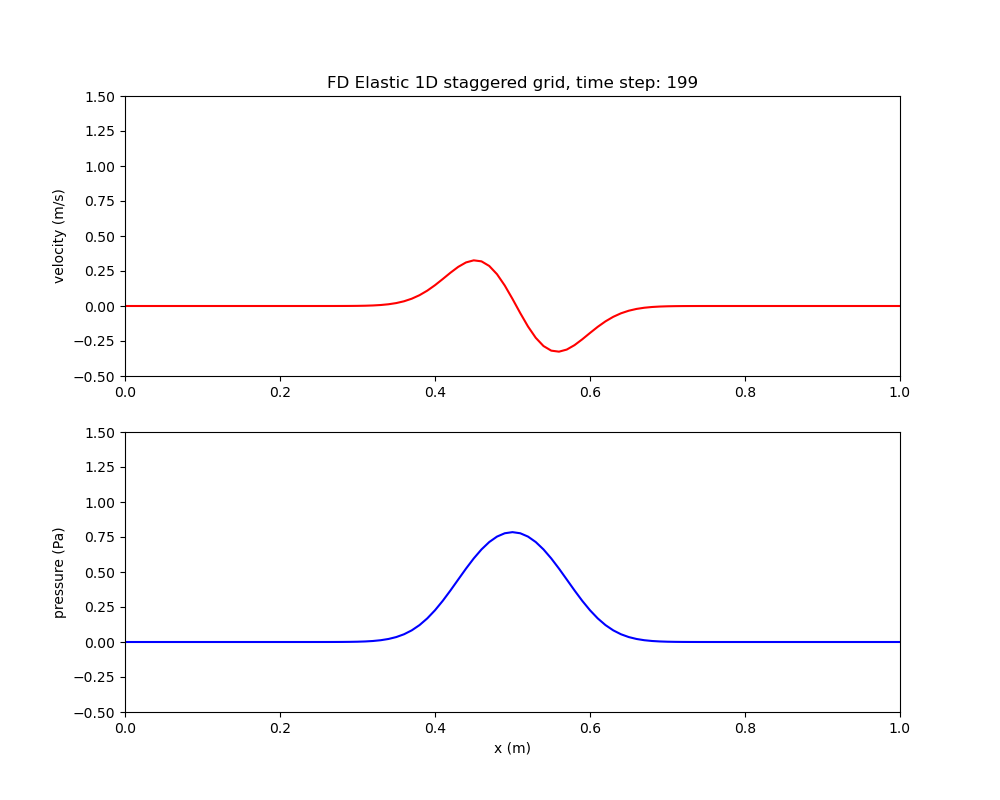

cpu (-1 means no new data generated): 6.655811


In [27]:
pulse(Nx=100,pulse_tp='gaussian',T=2, slowness_factor=1.0, sigma=0.05, loc='center', CFL=1, order=2)

<IPython.core.display.Javascript object>


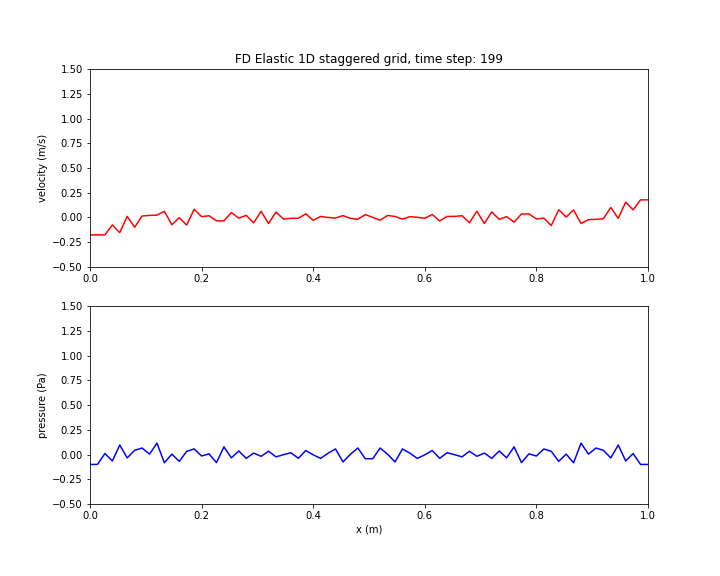

cpu (-1 means no new data generated): 5.5344729999999345


In [109]:
pulse(Nx=100,pulse_tp='plug',T=2, slowness_factor=1.0, sigma=0.05, loc='center', CFL=0.75)